<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_with_ITK_and_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

[The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute which has published over 175 unique data collections containing more than 60 million images. [ITK](https://itk.org/) is an open-source, cross-platform library that provides developers with an extensive suite of software tools for image analysis.  Developed through extreme programming methodologies, ITK builds on a proven, spatially-oriented architecture for processing, segmentation, and registration of scientific images in two, three, or more dimensions. Built on top of ITK, [itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) allows researchers to visualize images, point sets, and 3D geometry on the web in Jupyter notebooks. This notebook is focused on basic use cases for identifying TCIA datasets of interest and working with them in ITK and itkWidgets. 

# 1 Learn about available Collections on the TCIA website

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer most common questions you might have about the datasets.  

# 2 Searching and downloading data via the TCIA REST APIs 
TCIA uses a tool called NBIA to manage its DICOM data.  NBIA REST APIs are provided to the search and download functions used in the TCIA radiology portal, and allow access to both public and limited access collections.
1. The [NBIA Search REST APIs](https://wiki.cancerimagingarchive.net/x/fILTB) allow you to perform basic queries and download data from **public** collections. This API does not require a TCIA account.
2. The [NBIA Search with Authentication REST APIs](https://wiki.cancerimagingarchive.net/x/X4ATBg) allow you to perform basic queries and download data from **public and limited-access** collections. This API requires a TCIA account for creation of authentication tokens.
3. The [NBIA Advanced REST APIs](https://wiki.cancerimagingarchive.net/x/YoATBg) also allow access to **public and limited-access** collections, but provides query endpoints mostly geared towards developers seeking to integrate searching and downloading TCIA data into web and desktop applications.  This API requires a TCIA account for creation of authentication tokens.

Thise notebook will focus on the fully public [NBIA Search REST APIs](https://wiki.cancerimagingarchive.net/x/fILTB).  If you'd like to see examples using the other APIs check out [this notebook](https://github.com/kirbyju/TCIA_Notebooks/blob/main/ACNS0332/ACNS0332.ipynb) which shows many similar examples with the additional steps necessary to create a secure token using your TCIA login credentials.

***Note:*** Many of the examples below allow for additional query parameters to refine your search results.  These are covered in the documentation links above.

### 3.1 Explore public data with REST API Queries
In this section we'll look at how to query and download public data via the [NBIA Search REST APIs](https://wiki.cancerimagingarchive.net/x/fILTB).  The URL for accessing the Search APIs changes slightly depending on whether or not you would like to access the [National Lung Screening Trial (NLST)](https://doi.org/10.7937/TCIA.HMQ8-J677) collection, which lives on its own server due to its size (26,000+ patients, ~13 TBytes).  Here are the base URLs:

* All other Collections - https://services.cancerimagingarchive.net/nbia-api/services/v1/
* NLST - https://services.cancerimagingarchive.net/nlst-api/services/v1/




In [ ]:
# set API base URLs

base_url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/"
nlst_url = "https://services.cancerimagingarchive.net/nlst-api/services/v1/"

# imports

import requests
import pandas as pd
import json

We can also create reports that give useful metadata about each scan in the dataset (e.g. series description, modality, scanner manufacturer & software version, number of images).  We'll define a function for this one as well so we can use the JSON output in a more complex query later.  You must choose a collection, but modality is optional.

In [ ]:
# Define a function to return scan/series metadata for a collection as JSON 
# modality is optional

collection = "LIDC-IDRI"
modality = ""

def getSeries(collection, modality=""):
    if modality != "":
        data_url = base_url + "getSeries?Collection=" + collection + "&Modality=" + modality
        data = requests.get(data_url)
        if data.text != "":
            return data.json()
        else:
            print("No results: Please check to make sure the Collection " + collection + " exists and it contains " + modality + " modality.")
    else:
        data_url = base_url + "getSeries?Collection=" + collection
        data = requests.get(data_url)
        if data.text != "":
            return data.json()
        else:
            print("Collection not found.")

getSeries(collection, modality)

[{'SeriesInstanceUID': '1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818074696859567662357',
  'StudyInstanceUID': '1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118199124641098335511',
  'Modality': 'DX',
  'SeriesDate': '2000-01-01 00:00:00.0',
  'BodyPartExamined': 'CHEST',
  'SeriesNumber': 3000923,
  'AnnotationsFlag': True,
  'Collection': 'LIDC-IDRI',
  'PatientID': 'LIDC-IDRI-0001',
  'Manufacturer': 'GE MEDICAL SYSTEMS',
  'ManufacturerModelName': 'Revolution XQi ADS_28.2',
  'SoftwareVersions': 'Ads Application Package VERSION ADS_28.2',
  'ImageCount': 2,
  'TimeStamp': '2020-02-21 15:12:42.0'},
 {'SeriesInstanceUID': '1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192',
  'StudyInstanceUID': '1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178',
  'Modality': 'CT',
  'SeriesDate': '2000-01-01 00:00:00.0',
  'BodyPartExamined': 'CHEST',
  'SeriesNumber': 3000566,
  'AnnotationsFlag': True,
  'Collection': 'LIDC-IDRI',
  'PatientID': 'LIDC-IDRI-0001',
  

Let's save the output from that function in a dataframe so it's easier to view, analyze and export to CSV (if desired).

In [ ]:
collection = "LIDC-IDRI"
modality = ""

# call previously created getSeries function for a given Collection
data = getSeries(collection, modality)

# load it to a dataframe
df = pd.DataFrame(data)
display(df)

# optional - save to JSON or CSV file
#df.to_csv(collection+'_scan_metadata.csv')
# df.to_json(collection+'_scan_metadata.json')

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,BodyPartExamined,SeriesNumber,AnnotationsFlag,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,TimeStamp,SeriesDescription,ProtocolName
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...,DX,2000-01-01 00:00:00.0,CHEST,3000923.0,True,LIDC-IDRI,LIDC-IDRI-0001,GE MEDICAL SYSTEMS,Revolution XQi ADS_28.2,Ads Application Package VERSION ADS_28.2,2,2020-02-21 15:12:42.0,NaN,NaN
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,CT,2000-01-01 00:00:00.0,CHEST,3000566.0,True,LIDC-IDRI,LIDC-IDRI-0001,GE MEDICAL SYSTEMS,LightSpeed Plus,LightSpeedApps2.4.2_H2.4M5,133,2020-02-21 15:12:49.0,NaN,NaN
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...,DX,2000-01-01 00:00:00.0,CHEST,3000972.0,True,LIDC-IDRI,LIDC-IDRI-0002,GE MEDICAL SYSTEMS,Revolution XRd ADS_27.5.4,Ads Application Package VERSION ADS_27.5.4,1,2020-02-21 15:12:48.0,NaN,NaN
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,CT,2000-01-01 00:00:00.0,CHEST,3000522.0,True,LIDC-IDRI,LIDC-IDRI-0002,GE MEDICAL SYSTEMS,LightSpeed16,06MW03.5,261,2020-02-21 15:13:03.0,NaN,NaN
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,CT,2000-01-01 00:00:00.0,CHEST,3000611.0,True,LIDC-IDRI,LIDC-IDRI-0003,GE MEDICAL SYSTEMS,LightSpeed16,06MW03.5,140,2020-02-21 15:13:11.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15111,1.2.276.0.7230010.3.1.3.0.70138.1553357339.356319,1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054...,SR,2019-03-23 00:00:00.0,NaN,22.0,NaN,LIDC-IDRI,LIDC-IDRI-1011,QIICR,https://github.com/QIICR/dcmqi.git,f86b34f,1,2020-03-06 12:55:26.0,Nodule 3 - Annotation 162887 evaluations,NaN
15112,1.2.276.0.7230010.3.1.3.0.70134.1553357336.209938,1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054...,SR,2019-03-23 00:00:00.0,NaN,20.0,NaN,LIDC-IDRI,LIDC-IDRI-1011,QIICR,https://github.com/QIICR/dcmqi.git,f86b34f,1,2020-03-06 12:55:23.0,Nodule 3 - Annotation 1 evaluations,NaN
15113,1.2.276.0.7230010.3.1.3.0.70144.1553357348.831224,1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054...,SR,2019-03-23 00:00:00.0,NaN,28.0,NaN,LIDC-IDRI,LIDC-IDRI-1011,QIICR,https://github.com/QIICR/dcmqi.git,f86b34f,1,2020-03-06 12:55:21.0,Nodule 4 - Annotation 167770 evaluations,NaN
15114,1.2.276.0.7230010.3.1.3.0.70187.1553357377.190474,1.3.6.1.4.1.14519.5.2.1.6279.6001.676549258486...,SR,2019-03-23 00:00:00.0,NaN,32235.0,NaN,LIDC-IDRI,LIDC-IDRI-1012,QIICR,https://github.com/QIICR/dcmqi.git,f86b34f,1,2020-03-06 12:55:26.0,Nodule 1 - Annotation 157143 evaluations,NaN


In [ ]:
# Calculate summary statistics for a given collection 
collection = "CPTAC-LSCC"

# Call the getSeries function we created above
data = getSeries(collection)

# convert the output to dataframe
df = pd.DataFrame(data)

# Summarize patients
print('Summary Statistics\n')
print('Subjects: ', len(df['PatientID'].value_counts()), 'subjects')
print('Subjects: ', len(df['StudyInstanceUID'].value_counts()), 'studies')
print('Subjects: ', len(df['SeriesInstanceUID'].value_counts()), 'series')
print('Images: ', df['ImageCount'].sum(), 'images\n')

# Summarize modalities
print("Series Counts - Modalities:")
print(df['Modality'].value_counts(dropna=False),'\n')

# Summarize body parts
print("Series Counts - Body Parts Examined:")
print(df['BodyPartExamined'].value_counts(dropna=False),'\n')

# Summarize manufacturers
print("Series Counts - Device Manufacturers:")
print(df['Manufacturer'].value_counts(dropna=False))

Summary Statistics

Subjects:  39 subjects
Subjects:  63 studies
Subjects:  264 series
Images:  52072 images

Series Counts - Modalities:
CT    218
PT     20
CR     19
NM      5
DX      2
Name: Modality, dtype: int64 

Series Counts - Body Parts Examined:
CHEST             149
NaN                96
CHESTABDPELVIS     12
HEAD                5
CHESTABDOMEN        2
Name: BodyPartExamined, dtype: int64 

Series Counts - Device Manufacturers:
NaN                            79
GE MEDICAL SYSTEMS             73
Philips                        40
TOSHIBA                        26
Philips Medical Systems        14
Hitachi Medical Corporation    13
SIEMENS                        10
KONICA MINOLTA                  3
CARESTREAM HEALTH               2
GE MEDICAL SYSTEMS, NUCLEAR     2
"GE Healthcare"                 1
GE Healthcare                   1
Name: Manufacturer, dtype: int64


### 3.2 Downloading data with the REST API
Here are some examples of how to download data from ***public collections*** using the API.  In examples that would create large downloads there is some code included to limit the download to the first few series.  This can be commented out if you're ready to download full datasets.

Remember, if you'd like to see examples for downloading a ***restricted collection*** check out [this notebook](https://github.com/kirbyju/TCIA_Notebooks/blob/main/ACNS0332/ACNS0332.ipynb) which shows examples with the additional steps necessary to create a secure token using your TCIA login credentials.

In [ ]:
import pandas as pd
import requests, zipfile
from io import BytesIO

Now let's define a generic download function that we can re-use for the remaining use cases.  This will take a list of series UIDs as the input, download each scan, and create a dataframe/CSV that contains the metadata about each of those scans.  It also accepts an optional parameter to specify a file name if you'd like a CSV export of the dataframe.

In [ ]:
# define a function to accept a list of seriesInstanceUIDs and download it
# reminder: this only downloads the first 3 scans unless you comment out that section

def downloadSeries(series_data, csv_filename=""):  
    manifestDF=pd.DataFrame()
    seriesUID = ''
    count = 0
    for x in series_data:
        seriesUID = x['SeriesInstanceUID']
        data_url = base_url + "getImage?SeriesInstanceUID=" + seriesUID
        print("Downloading " + data_url)
        data = requests.get(data_url)
        file = zipfile.ZipFile(BytesIO(data.content))
        # print(file.namelist())
        file.extractall(path = "apiDownload/" + collection + "/" + seriesUID)
        # write the series metadata to a dataframe
        metadata_url = base_url + "getSeriesMetaData?SeriesInstanceUID=" + seriesUID
        metadata = requests.get(metadata_url).json()
        newRow = pd.DataFrame.from_dict(metadata)
        tmpManifest = pd.concat([manifestDF, newRow], ignore_index = True)
        tmpManifest.reset_index()
        manifestDF = tmpManifest
        # Repeat n times for demo purposes - comment out these next 3 lines to download a full results
        count += 1;
        if count == 3:
            break  
    # display manifest dataframe and/or save manifest to CSV file
    if csv_filename != "":
        manifestDF.to_csv(csv_filename + '.csv')
        display(manifestDF)
    else:
        display(manifestDF)

We can also leverage the flexability to specify Collection + modality for the getSeries function and feed that subset to the downloadSeries function.

In [ ]:
# choose collection
collection = "NSCLC-Radiomics"
modality = "SEG"

# call getSeries function to retrieve scan metadata for the whole collection
series_data = getSeries(collection, modality)

# feed series_data to our downloadSeries function
downloadSeries(series_data, collection + "_full_Collection")

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,File Location,Series Number,License Name,License URL,Annotation Size
0,1.2.276.0.7230010.3.1.3.2323910823.11644.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-005,1.3.6.1.4.1.32722.99.99.7196186628043392557101...,01-01-2014,Segmentation,QIICR,SEG,1.2.840.10008.5.1.4.1.1.66.4,1,18220546,StudyID,300.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
1,1.2.276.0.7230010.3.1.3.2323910823.20524.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,09-18-2008,Segmentation,QIICR,SEG,1.2.840.10008.5.1.4.1.1.66.4,1,17891830,StudyID,300.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0
2,1.2.276.0.7230010.3.1.3.2323910823.11436.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-009,1.3.6.1.4.1.32722.99.99.1737446948497249041452...,01-01-2014,Segmentation,QIICR,SEG,1.2.840.10008.5.1.4.1.1.66.4,1,17521798,StudyID,300.000000,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,0


It's possible to use https://nbia.cancerimagingarchive.net to create a "[Shared Cart](https://wiki.cancerimagingarchive.net/display/NBIA/TCIA+Radiology+Portal+User+Guide#TCIARadiologyPortalUserGuide-SharingDatainYourCart)" which includes a specific set of scans you'd like to share with others. After creating a Shared Cart you receive a URL like https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-49121659384603347 which can be shared with others.  Try clicking the link to see what this looks like on the TCIA website.  Then use the code below to see how you can use the cart name to download the (first 3) related scans via our API.

In [ ]:
# Download a "Shared Cart" that has been previously created via the NBIA GUI (https://nbia.cancerimagingarchive.net)

cartName="nbia-49121659384603347"

cart_URL = base_url + "getContentsByName?name=" + cartName
series_data = requests.get(cart_URL).json()

# feed series_data to our downloadSeries function
downloadSeries(series_data, collection + "_full_Collection")

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class UID,Number of Images,File Size,Series Number,License Name,License URL,Annotation Size
0,1.2.276.0.7230010.3.1.3.1070885483.15960.15991...,PROSTATEx,yes,https//doi.org/10.7937/tcia.nbb4-4655,ProstateX-0004,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR prostaat kanker detectie WDSmc MCAPRODETW,10-18-2011,Segmentation,QIICR,SEG,1.2.840.10008.5.1.4.1.1.66.4,1,1450544,300.000000,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,0
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,Pediatric-CT-SEG,NO,https://doi.org/10.7937/TCIA.X0H0-1706,Pediatric-CT-SEG-00DCF4D6,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,10-09-2009,RTSTRUCT,Varian Medical Systems,RTSTRUCT,1.2.840.10008.5.1.4.1.1.481.3,1,15459192,2.000000,NaN,NaN,0
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,Pediatric-CT-SEG,NO,https://doi.org/10.7937/TCIA.X0H0-1706,Pediatric-CT-SEG-00DCF4D6,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,10-09-2009,CT,GE MEDICAL SYSTEMS,CT,1.2.840.10008.5.1.4.1.1.2,207,109041294,30144.000000,NaN,NaN,0


#4 Loading DICOM Images and RTStructs as ITK Images and Numpy Arrays

In [ ]:
# install itk for DICOM I/O and for reading DICOM into an itk Image that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions which are critical to image processing and display
!pip install --upgrade --pre itk

# install rt-utils for reading DICOM RT-Struct objects
!pip install --upgrade rt-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.2 MB 2.6 MB/s 
     |████████████████████████████████| 83.5 MB 65 kB/s 
     |████████████████████████████████| 75.9 MB 1.3 MB/s 
     |████████████████████████████████| 27.3 MB 1.3 MB/s 
     |████████████████████████████████| 60.0 MB 1.2 MB/s 
     |████████████████████████████████| 17.2 MB 35.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [ ]:
# TCIA data import utils
import requests
import json
import requests, zipfile
import pandas as pd
from io import BytesIO

# Include ITK for DICOM reading
import itk

import numpy as np

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks
from rt_utils import RTStructBuilder

In [ ]:
# Download a "Shared Cart" that has been previously created via the NBIA webset (https://nbia.cancerimagingarchive.net)
cartName = "nbia-49121659384603347"

cart_URL = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=" + cartName
cart_data = requests.get( cart_URL ).json()

# Convert the metadata downloaded to a pandas dataframe for easy access and manipulation
df = pd.DataFrame( cart_data )

# Let's just local the data in the cart that came from the Pediatric-CT-SEG study (optional, done to save time/memory for this demo)
study_df = df.query( 'Collection=="Pediatric-CT-SEG"' )

display( study_df )

display( df )

# Here are the URLs that correspond to the series in that study
series_uids = [ seriesUID for seriesUID in study_df['SeriesInstanceUID'] ]
# Go through the Series in the cart, and download them
TCIA_base_url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?SeriesInstanceUID="
dicom_data_dir = "dicomData/"
for series_uid in series_uids:
        print( "Downloading", series_uid )
        request = requests.get( TCIA_base_url + series_uid )
        file = zipfile.ZipFile( BytesIO(request.content) )
        file.extractall( path = dicom_data_dir + series_uid )
        print("   ...done.")

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,ProtocolName
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,RTSTRUCT,NaN,RTSTRUCT,NaN,2,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,Varian Medical Systems,ARIA RTM,4.2.7.0,1,NaN
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,2009-10-09 00:00:00.0,CT,ABDOMEN,30144,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,GE MEDICAL SYSTEMS,Revolution CT,revo_ct_21a.33,207,NaN


,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,ProtocolName
0,1.2.276.0.7230010.3.1.3.1070885483.15960.15991...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,SEG,2020-09-03 00:00:00.0,Segmentation,PROSTATE,300,PROSTATEx,ProstateX-0004,QIICR,https://github.com/qiicr/dcmqi.git,1e82977,1,NaN
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,RTSTRUCT,NaN,RTSTRUCT,NaN,2,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,Varian Medical Systems,ARIA RTM,4.2.7.0,1,NaN
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,2009-10-09 00:00:00.0,CT,ABDOMEN,30144,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,GE MEDICAL SYSTEMS,Revolution CT,revo_ct_21a.33,207,NaN
3,1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR,2011-10-18 00:00:00.0,t2_tse_tra,PROSTATE,5,PROSTATEx,ProstateX-0004,SIEMENS,Skyra,syngo MR D11,19,t2_tse_tra


   ...done.
   ...done.


In [ ]:
# Use the data frame for the Pediatric study (study_df) to find the first Series Instance ID where the Modality is CT. 
ct_series_uid = study_df.SeriesInstanceUID[study_df.Modality.eq('CT').idxmax()]
# The series_uid defines where the series was stored on disk
dicom_ct_dir = dicom_data_dir + ct_series_uid

# Use the Pediatric study's data frame to find the first Series Instance ID where the Modality is RTSTRUCT.
#    On TCIA, the rtstruct file is the first .dcm file in that dir.  To be generic, could use glob to get that filename, but this will work in most cases
rtstruct_series_uid = study_df.SeriesInstanceUID[study_df.Modality.eq('RTSTRUCT').idxmax()]
dicom_rtstruct_file = dicom_data_dir + rtstruct_series_uid + "/00000001.dcm"

In [ ]:
# Read the DICOM CT series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
dicom_image = itk.imread(dicom_ct_dir, itk.F)

In [ ]:
# We use RT-Utils to read in the list of contours (ROIs) available in the RT-STRUCT file.  This also requires passing-in the path to the original
#   DICOM series (image) so that labelmaps images can be generated from the RT-STRUCT contours.
rt_struct = RTStructBuilder.create_from(dicom_series_path=dicom_ct_dir, rt_struct_path=dicom_rtstruct_file)

In [ ]:
# RT-Utils has many useful functions, including the ability to list the names of the ROIs available in the RT-STRUCT file
print(rt_struct.get_roi_names())

['Bones', 'Skin', 'Lung_R', 'UteroCervix', 'Thymus', 'Stomach', 'Spleen', 'Spinal Canal', 'Small Intestine', 'Rectum', 'Prostate', 'Pancreas', 'Liver', 'Large Intestine', 'Kidney Right', 'Kidney Left', 'Heart', 'Gonads', 'Gall Bladder', 'Femoral Head Rig', 'Femoral Head Lef', 'Esophagus', 'Duodenum', 'Breast Right', 'Breast Left', 'Bladder', 'Adrenal Right', 'Adrenal Left', 'Lung_L']


In [ ]:
# Read in the bones contour as a numpy array.  We must also convert convert it to float (for possible future filtering, MONAI, etc.), and realign the axis to 
#   correspond with how images are stored by ITK.  This realignment typically isn't needed, but rt-utils requires it.
#   Note: The copy() call is required to force the transpose to actually reorder the data in memory versus maintain an abstraction.
bones_array = rt_struct.get_roi_mask_by_name("Bones").astype(np.float32).transpose(2,0,1).copy()

# As an np array, the rtstruct labelmap is missing critical information about pixel spacing, image origin, image orientation, etc.
#    Here we create an itk image from the numpy array, and we copy the critical information from itk image created from the 
#    original DICOM CT data.
bones_labelmap = itk.GetImageFromArray(bones_array)
bones_labelmap.CopyInformation(dicom_image)

# If desired, we can also convert the DICOM image in memory from ITK Image format to Numpy format.
#    Note: By calling GetArrayViewFromImage() instead of GetArrayFromImage(), the Numpy array uses the same memory used by the
#    ITK image, so conversion is nearly instantaneous, does not require additional memory, and changes to the numpy array will
#    cause changes to the ITK image.   This is great when applying a sequence of ITK and numpy filters, etc.
dicom_array = itk.GetArrayViewFromImage(dicom_image)

In [ ]:
# Print out the primary info stored with an itk image (not all dicom elements are shown)
print(dicom_image)

Image (0x857f700)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 41601
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 222
  UpdateMTime: 41600
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  Spacing: [0.585938, 0.585938, 2]
  Origin: [-139.39, -150, -429.45]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.585938 0 0
0 0.585938 0
0 0 2

  PointToIndexMatrix: 
1.70667 0 0
0 1.70667 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x9fefb30)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Cou

# 5 3D Visualization in Colab, Sagemaker, or Jupyter using itkWidgets

itkWidgets provides interactive 3D visualizations of ITK images, Numpy arrays, point clouds, vtk polydata, and much more within a jupyter notebook / jupyter lab!!!   https://github.com/InsightSoftwareConsortium/itkwidgets

When working on medical images in Google Colab, AWS Sagemaker, or on a jupyter instance running on your local computer, it can be useful to interactively visualize your images and segmentations (RTStruct / SEG objects) without having to exit the notebook/lab, export the data, or such.

The following cells assume that that cells in the previous section of this notebook "Loading DICOM Series Images and RTStructs as ITK Images and Numpy Arrays" have already been run.  They load the image and labelmap data into the dicom_image and bones_labelmap python variables.

In [ ]:
# install itkwidgets for interactive visualization in a colab or sagemaker
!pip install --upgrade --pre itkwidgets>=1.0a15

# if running on a local (desktop installed) jupyter notebook, use this command instead
#!pip install --upgrade --pre itkwidgets[notebook]>=1.0a14
# if running on a local (desktop installed) jupyter lab, use this command instead
#!pip install --upgrade --pre itkwidgets[lab]>=1.0a14

In [ ]:
# The most commonly used function in itkwidgets is view(), but there are also functions for checkerboard
#   viewing of registration results, and more.   More information is available at
#      https://github.com/InsightSoftwareConsortium/itkwidgets
from itkwidgets import view

**You must re-run the following cells when you re-load the colab notebook.**


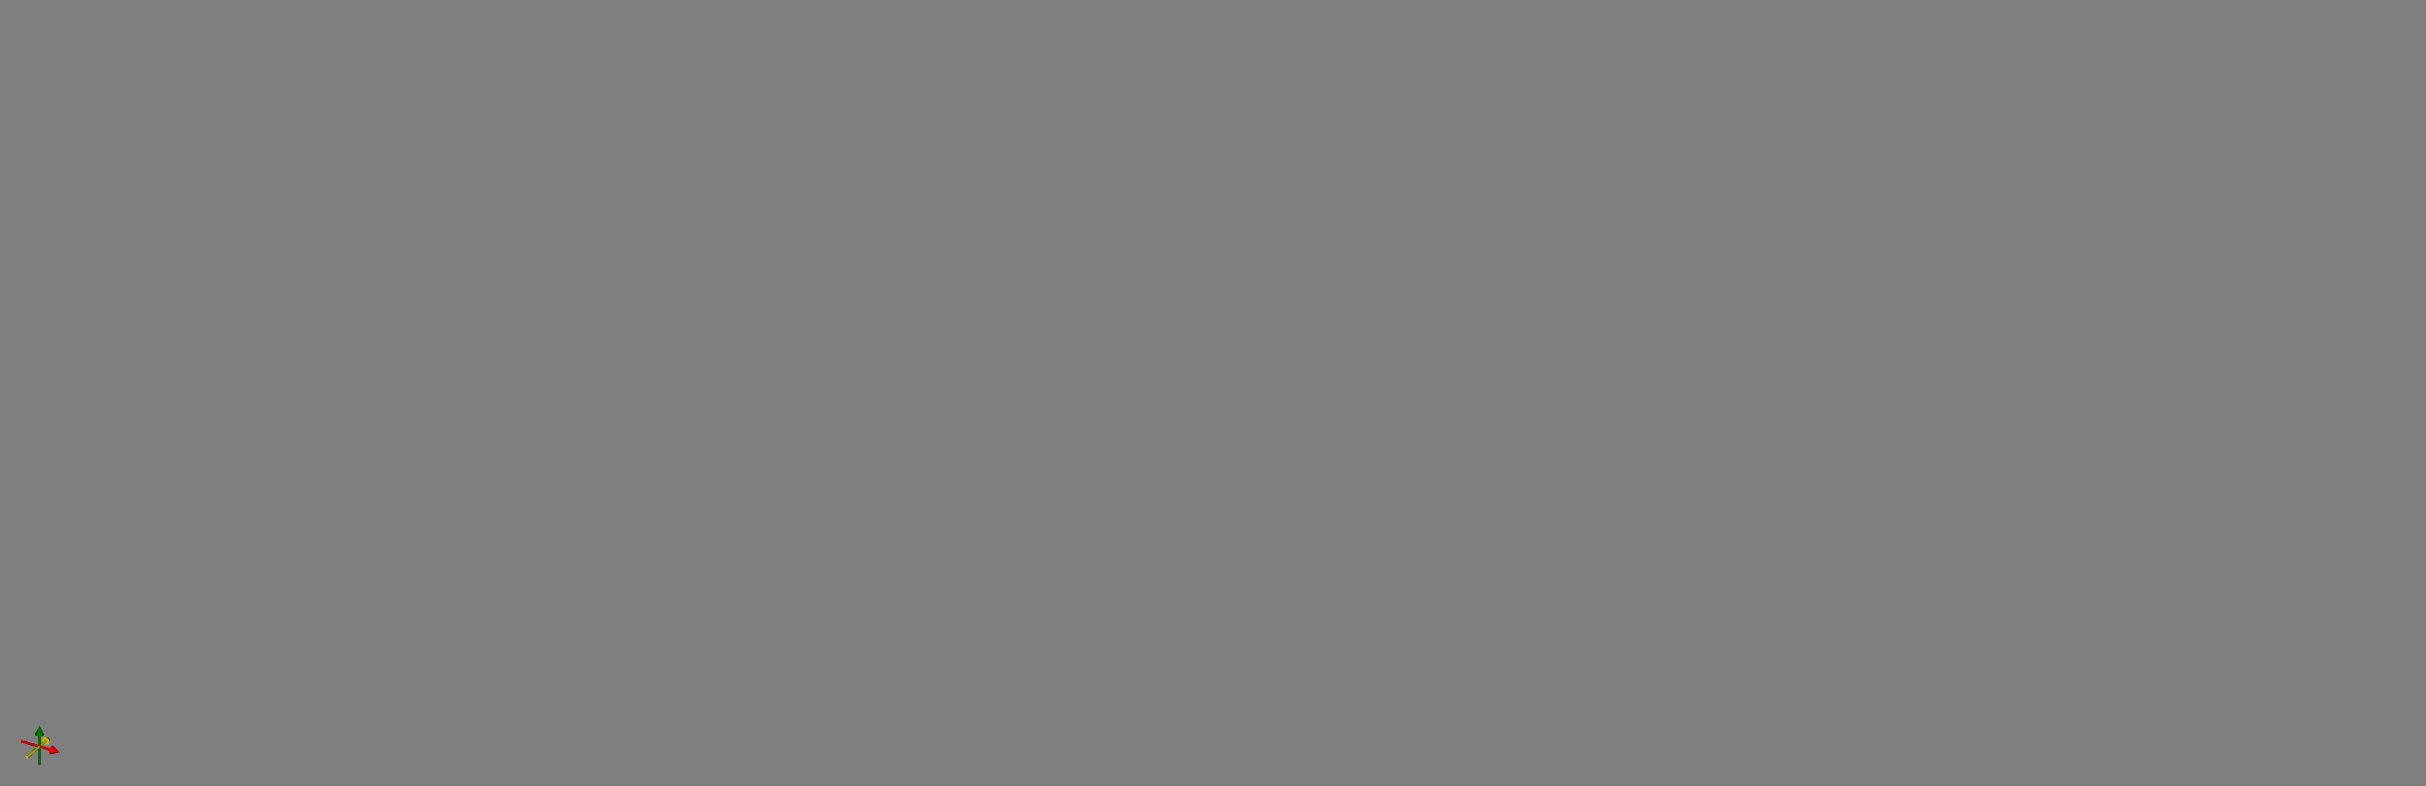
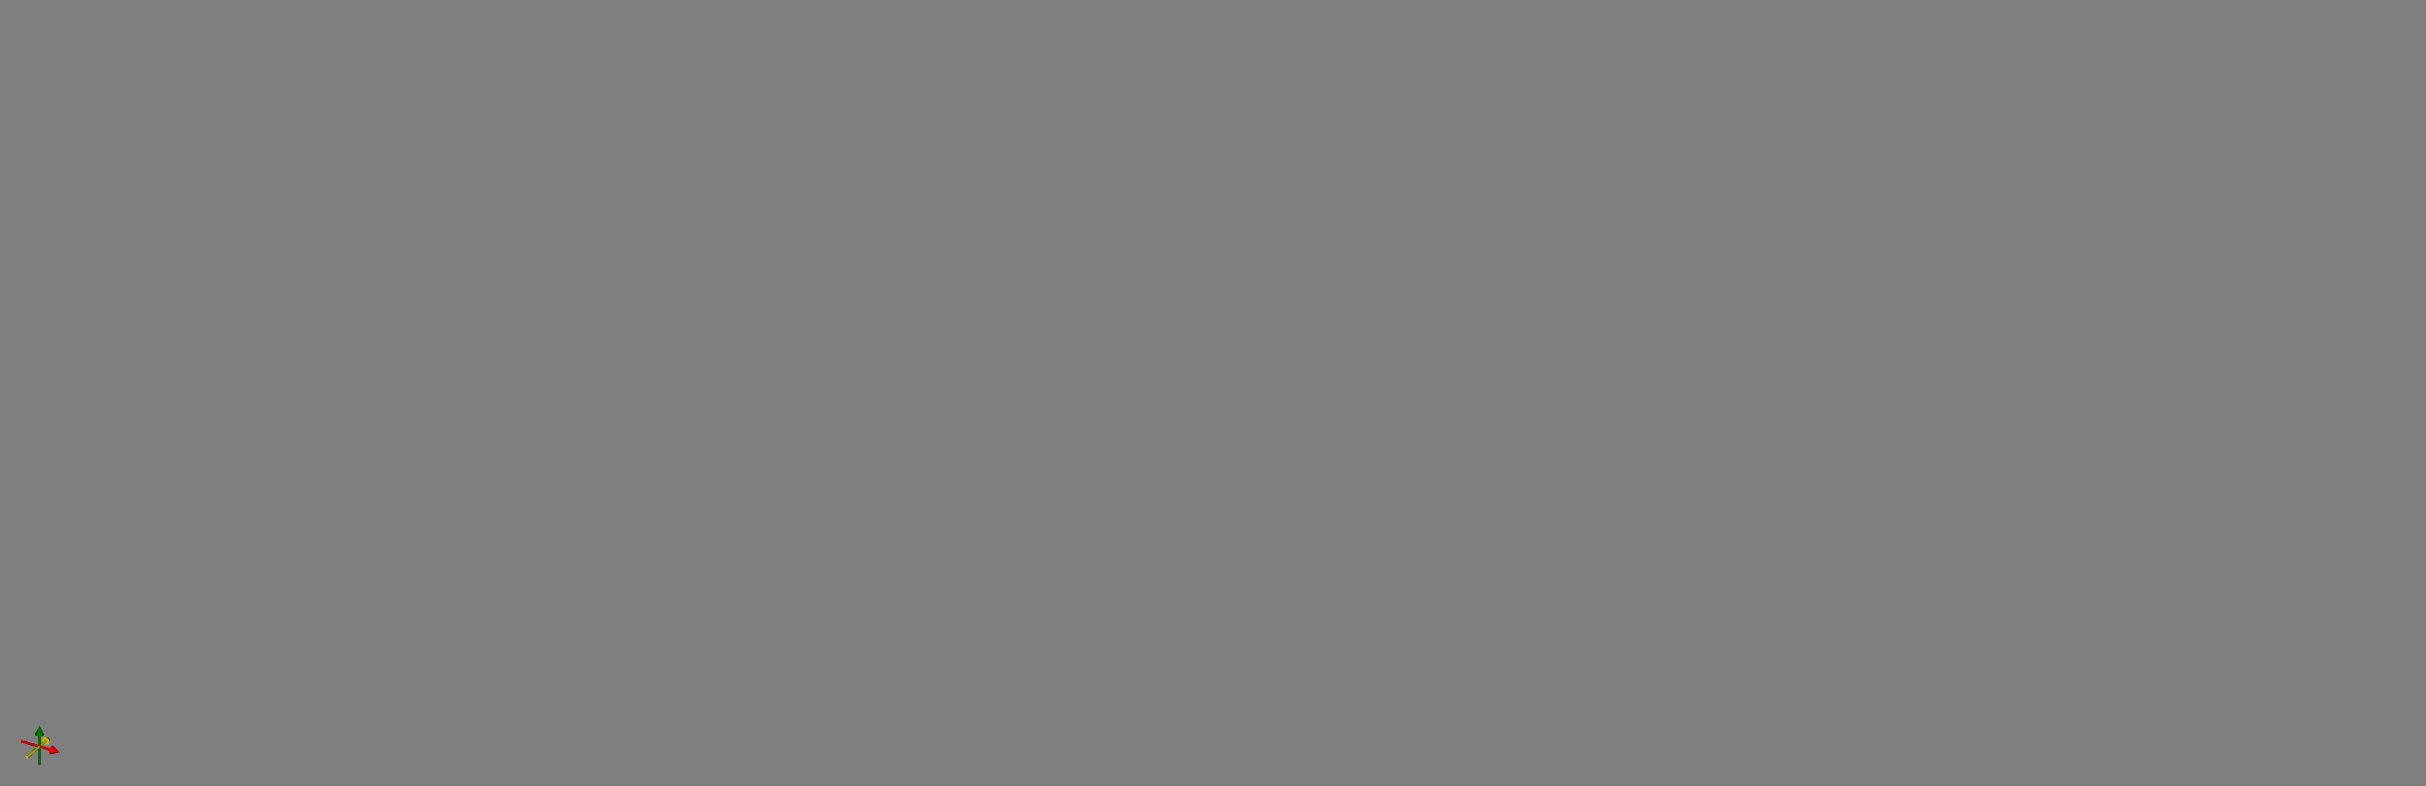

In [ ]:
# First we create the viewer:  ()
viewer = view()

In [ ]:
# Then load the image (or point clouds or polygons or numpy arrays or ...) into the view
#    Note after the load completes, it takes ~20 seconds for the data to appear in Colab and Sagemaker.  It is nearly instantaneous on local jupyter notebook/lab.
#    Also, the display is a multi-resolution display, so first coarse versions of the data will be loaded, and then a final high-resolution version - due to data transfer limitations on Colab and Sagemaker.
viewer.set_image(dicom_image)

# You can also add the bones_labelmap as an overlay
viewer.set_label_image(bones_labelmap)

# We will also display the menu, so that you can control the viewing options
viewer.set_ui_collapsed(False)

# Try moving the "Gradient Opacity" slider below the transfer function editor to make the image more (or less) transparent and the labelmap easier (or harder) to see.

In [ ]:
# You can also programmatically change many viewing options, such as
viewer.set_view_mode('Volume')
viewer.set_image_color_map("Black-Body Radiation")
viewer.set_image_color_range([100,600])
viewer.set_image_gradient_opacity(0.1)
viewer.set_label_image_blend(0.3)
viewer.set_image_volume_sample_distance(0.05)

In [ ]:
# You can also simply view the data as 2D slices
viewer.set_image_color_map("Grayscale")
viewer.set_image_color_range([-500,300])
viewer.set_label_image_blend(0.5)
viewer.set_view_mode('ZPlane')
viewer.set_z_slice(-146)


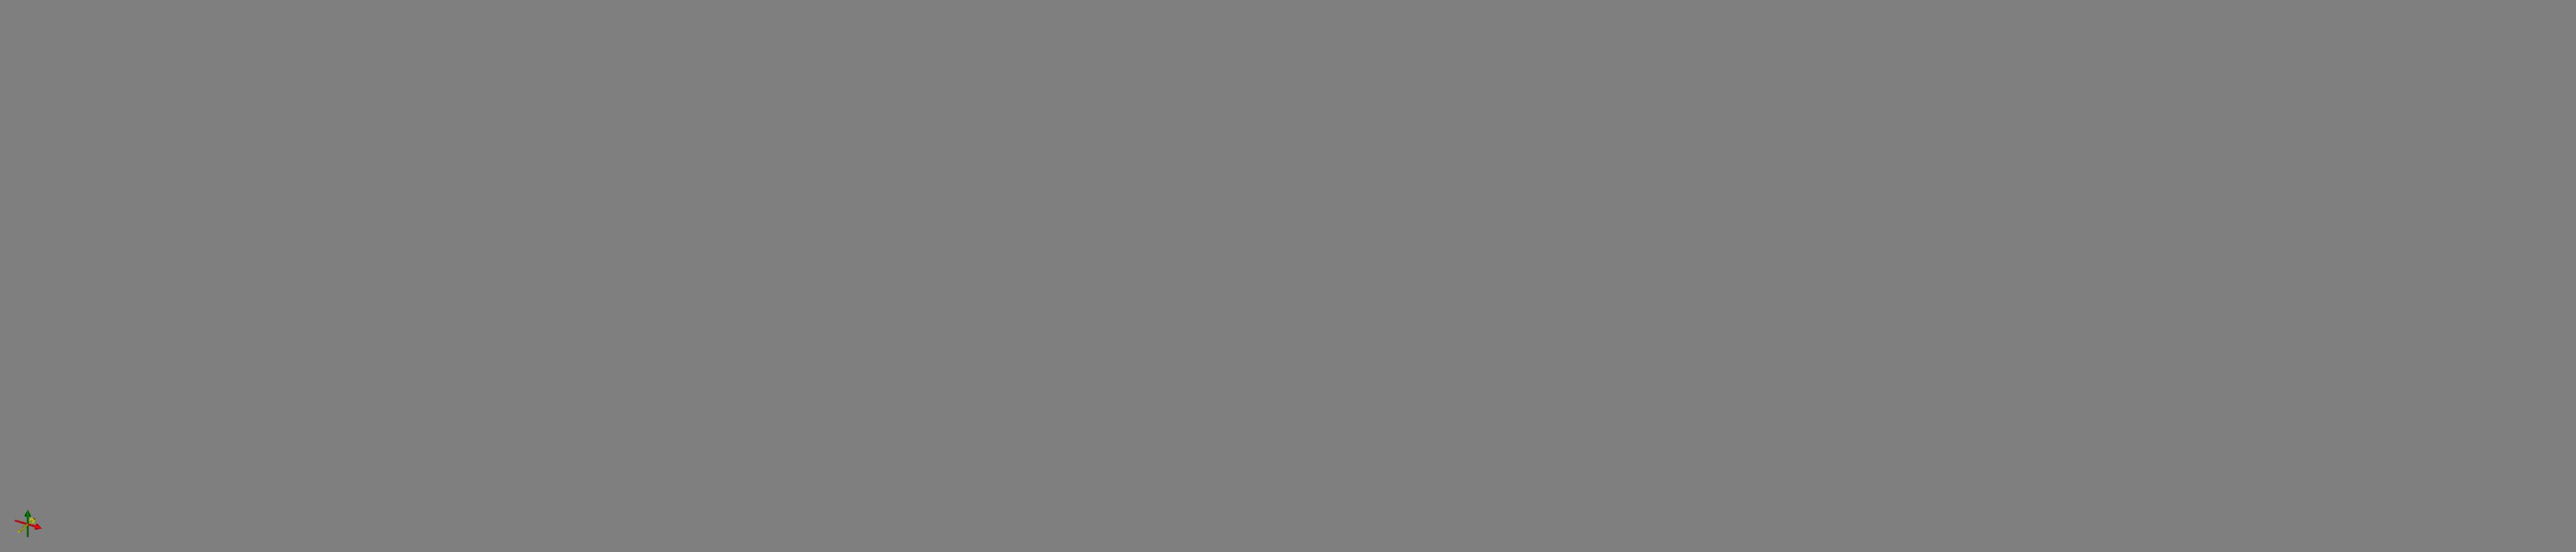
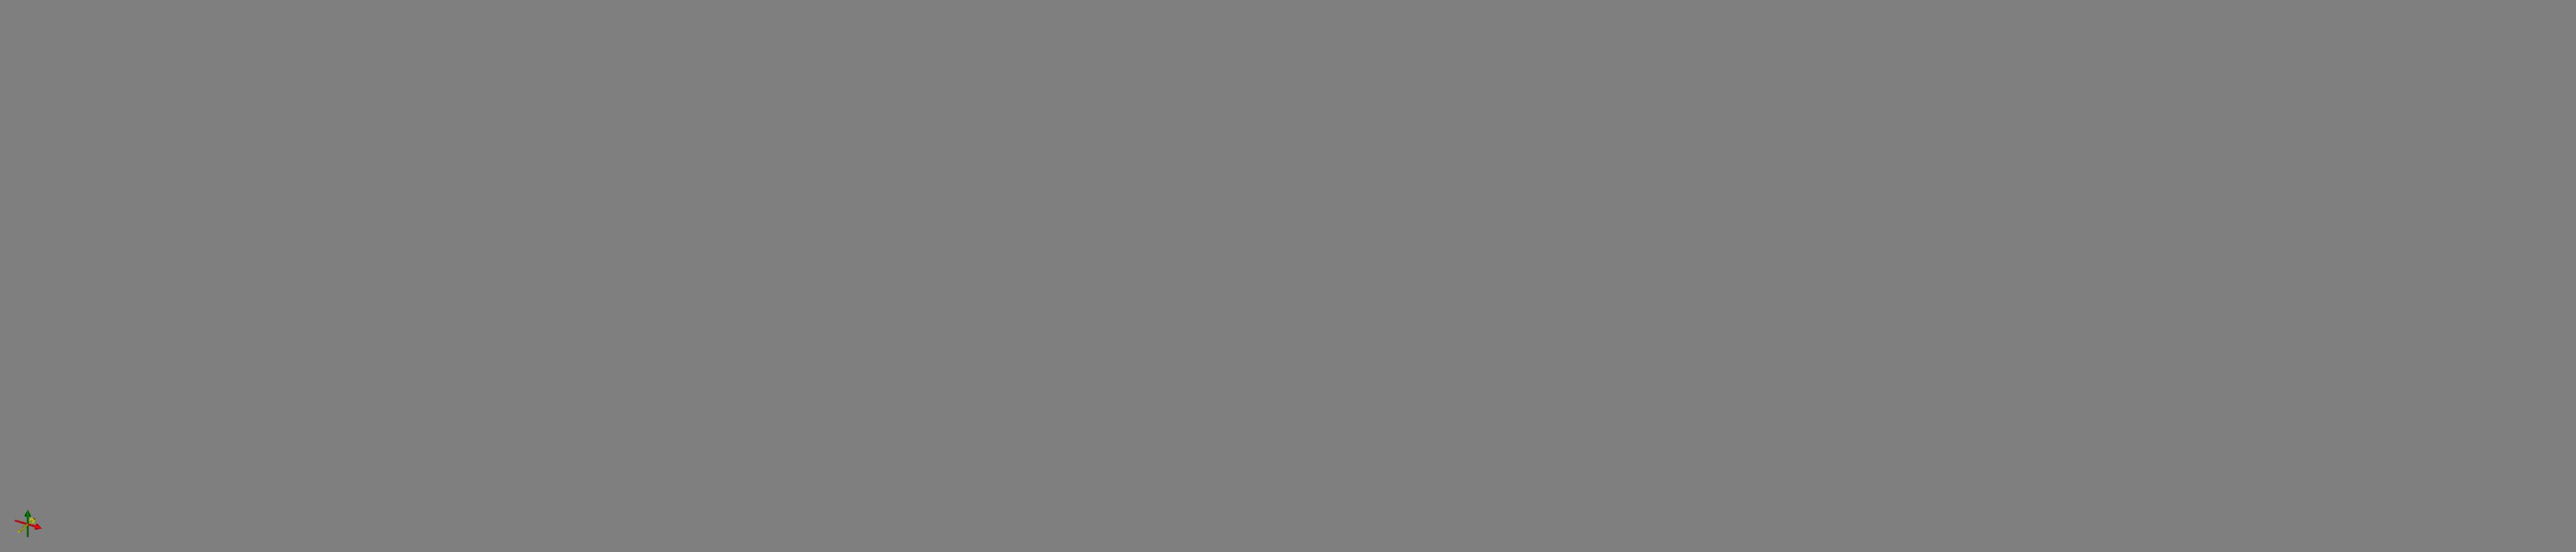

In [ ]:
viewer2 = view()

In [ ]:
viewer2.set_image(dicom_image)

# 6 Data Visualization Using OHIF




Server-side 2D visualization of specific scans in a browser is possible by using our OHIF Viewer if you know the Series Instance UID of the scan you'd like to view.  For example: https://nbia.cancerimagingarchive.net/viewer/?series=1.3.6.1.4.1.14519.5.2.1.7311.5101.225402322918877902268269283832.  

NCI also funds a project called the [Imaging Data Commons](https://portal.imaging.datacommons.cancer.gov/), which can be useful for visualizing and analyzing TCIA's public datasets.  They currently do not host any of our limited-access Collections.  

You can use the code below to pull up specific studies/series of interest using a StudyInstanceUID or SeriesInstanceUID.  The significant advantage to using the IDC viewer is that their version of OHIF supports loading entire studies (not just individual series) and also overlaying annotations/segmentations.  After entering a UID of interest, run the cell below and click the link to open up their viewer in your browser.

In [ ]:
# helper function to view a study or a specific series hosted by IDC
def get_idc_viewer_url(studyUID, seriesUID=None):
  url = "https://viewer.imaging.datacommons.cancer.gov/viewer/"+studyUID
  if seriesUID is not None:
    url = url+"?seriesInstanceUID="+seriesUID
  return url

print(get_idc_viewer_url("1.3.6.1.4.1.14519.5.2.1.6279.6001.321085339464682432111441689315"))

https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.14519.5.2.1.6279.6001.321085339464682432111441689315


# Acknowledgements
TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

This notebook was created by [Justin Kirby](https://www.linkedin.com/in/justinkirby82/) and Qinyan Pan.  If you leverage this notebook or any TCIA datasets in your work please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to the following paper!

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7